In [ ]:
# Importing general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Time Series Library
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Deep Learning Libraries
!pip install -q keras-tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Load the dataset
file_path = "/content/weather_2016_2020_daily.csv"
df = pd.read_csv(file_path, parse_dates=["Date"])


df.set_index("Date", inplace=True)

# Fill missing values using forward fill
df.fillna(method='ffill', inplace=True)

# Select features
features = ['Temp_max', 'Temp_avg', 'Temp_min',
            'Hum_max', 'Hum_avg', 'Hum_min',
            'Wind_max', 'Wind_avg', 'Wind_min',
            'Press_max', 'Press_avg', 'Press_min',
            'Precipit']
df = df[features]


In [ ]:
df.head(5)

,Temp_max,Temp_avg,Temp_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit
Date,,,,,,,,,,,,,
2016-01-06,85,74.8,68,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00
2016-02-06,76,71.2,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33
2016-03-06,79,72.1,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18
2016-04-06,76,71.2,69,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37
2016-05-06,82,73.8,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39


In [ ]:
# check the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1552 entries, 2016-01-06 to 2020-08-30
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Temp_max   1552 non-null   int64  
 1   Temp_avg   1552 non-null   float64
 2   Temp_min   1552 non-null   int64  
 3   Hum_max    1552 non-null   int64  
 4   Hum_avg    1552 non-null   float64
 5   Hum_min    1552 non-null   int64  
 6   Wind_max   1552 non-null   int64  
 7   Wind_avg   1552 non-null   float64
 8   Wind_min   1552 non-null   int64  
 9   Press_max  1552 non-null   float64
 10  Press_avg  1552 non-null   float64
 11  Press_min  1552 non-null   float64
 12  Precipit   1552 non-null   float64
dtypes: float64(7), int64(6)
memory usage: 169.8 KB


In [ ]:
# Check the first date
first_date = df.index.min()

# Check the last date
last_date = df.index.max()

# Print results
print(f"First date in dataset: {first_date}")
print(f"Last date in dataset: {last_date}")


First date in dataset: 2016-01-06 00:00:00
Last date in dataset: 2020-12-08 00:00:00


In [ ]:
df.isna().sum() / len(df)

,0
Temp_max,0.0
Temp_avg,0.0
Temp_min,0.0
Hum_max,0.0
Hum_avg,0.0
Hum_min,0.0
Wind_max,0.0
Wind_avg,0.0
Wind_min,0.0
Press_max,0.0


<Axes: xlabel='Date'>

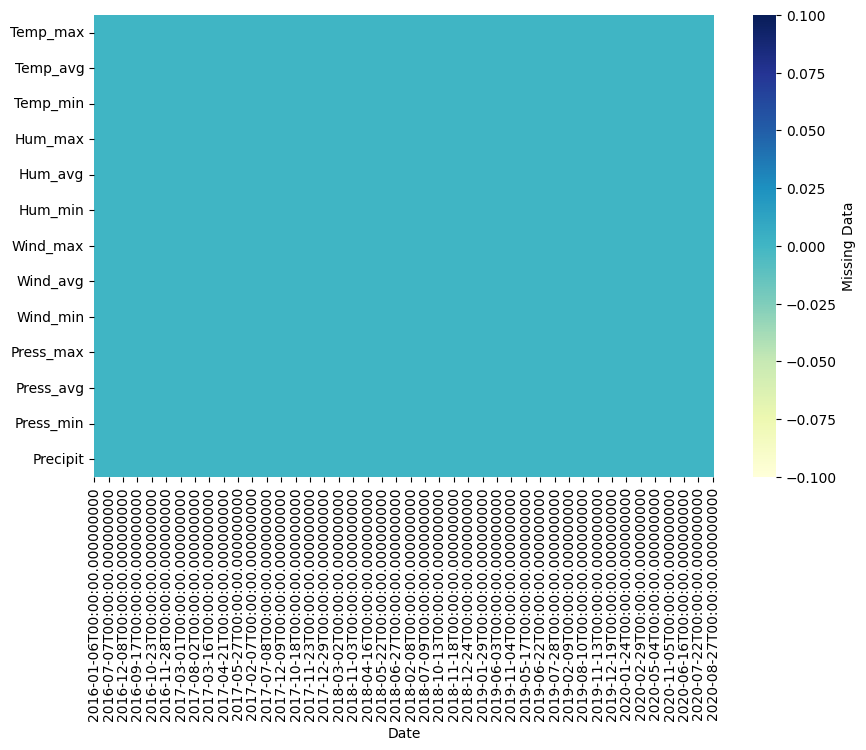

In [ ]:
# Visualizing Missing Data using a seaborn heatmap.
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [ ]:
# Basic summary of the dataset
eda_summary = {
    "Number of Rows": df.shape[0],
    "Number of Columns": df.shape[1],
    "Missing Values": df.isnull().sum().sum(),
    "Duplicate Rows": df.duplicated().sum()
}

# Data types of each column
data_types = df.dtypes.value_counts()

# Displaying findings
eda_summary, data_types

({'Number of Rows': 1552,
  'Number of Columns': 13,
  'Missing Values': np.int64(0),
  'Duplicate Rows': np.int64(0)},
 float64    7
 int64      6
 Name: count, dtype: int64)

In [ ]:
df.describe()

,Temp_max,Temp_avg,Temp_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit
count,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000
mean,81.287371,71.752320,63.338273,92.566366,74.365786,51.204897,15.855026,7.734987,1.375000,29.973840,29.903479,29.813273,0.157893
std,12.723409,12.490526,13.614699,7.658203,11.700804,15.601436,4.842882,2.989969,2.500516,0.165958,0.160434,0.773583,0.658309
min,34.000000,27.600000,0.000000,50.000000,31.500000,0.000000,6.000000,1.600000,0.000000,29.500000,28.800000,0.000000,0.000000
25%,74.000000,63.175000,52.750000,90.000000,67.400000,41.000000,13.000000,5.700000,0.000000,29.900000,29.800000,29.700000,0.000000
50%,84.000000,74.300000,67.000000,94.000000,75.000000,50.000000,15.000000,7.300000,0.000000,29.900000,29.900000,29.800000,0.000000
75%,92.000000,82.000000,75.000000,97.000000,82.700000,61.000000,18.000000,9.400000,3.000000,30.100000,30.000000,29.900000,0.020000
max,101.000000,90.000000,83.000000,100.000000,99.900000,97.000000,39.000000,23.900000,17.000000,30.600000,30.600000,30.500000,13.430000


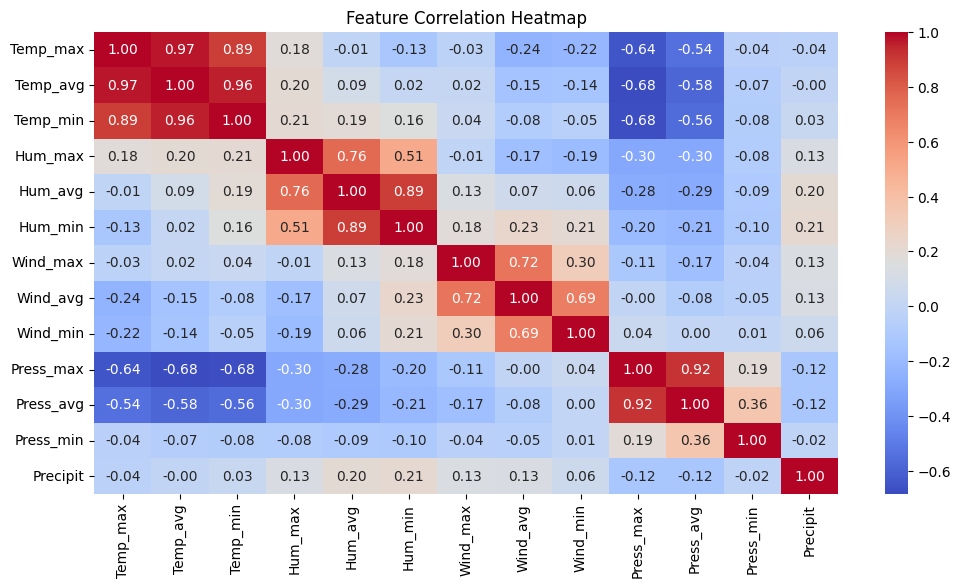

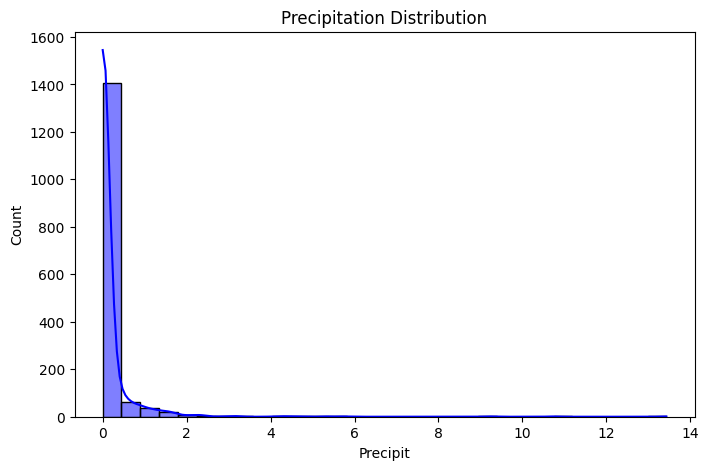

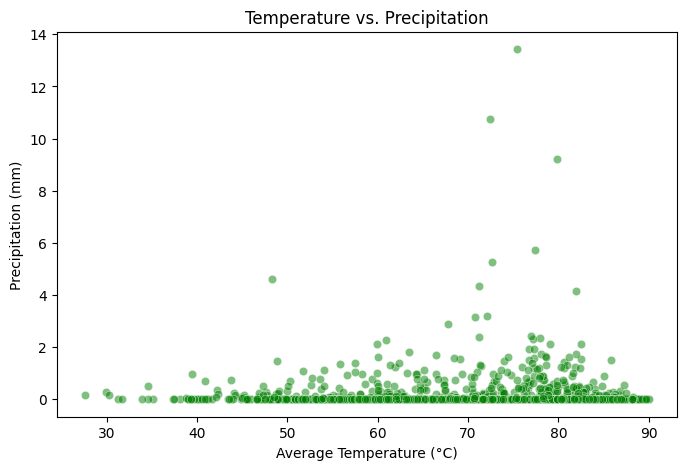

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Precipitation Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Precipit"], bins=30, kde=True, color="blue")
plt.title("Precipitation Distribution")
plt.show()

# Temperature vs. Precipitation Scatter Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Temp_avg"], y=df["Precipit"], alpha=0.5, color="green")
plt.title("Temperature vs. Precipitation")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Precipitation (mm)")
plt.show()


In [ ]:
# Create Lag Features (1 to 7 days lag for Precipit)
for lag in range(1, 8):
    df[f'Precipit_lag_{lag}'] = df['Precipit'].shift(lag)

# Create Rolling Window Features
df['Precipit_3d_avg'] = df['Precipit'].rolling(window=3).mean()
df['Precipit_7d_avg'] = df['Precipit'].rolling(window=7).mean()
df['Precipit_7d_std'] = df['Precipit'].rolling(window=7).std()

# Create Time-based Features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear

# Remove NaN values produced by lag and rolling windows
df.dropna(inplace=True)

In [ ]:
# Define Features and Target Variable for classical models
X = df.drop(columns=['Precipit'])
y = df['Precipit']

# Split the data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Save training columns.
X_train_columns = X_train.columns.tolist()

# Feature Scaling using StandardScaler
scaler_std = StandardScaler()
X_train_scaled = scaler_std.fit_transform(X_train)
X_test_scaled = scaler_std.transform(X_test)




In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize baseline RF model
rf_baseline = RandomForestRegressor(random_state=42)
rf_baseline.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf_base = rf_baseline.predict(X_test_scaled)

# Evaluate
mse_rf_base = mean_squared_error(y_test, y_pred_rf_base)
mae_rf_base = mean_absolute_error(y_test, y_pred_rf_base)
r2_rf_base = r2_score(y_test, y_pred_rf_base)

print("\nRandom Forest (Before Tuning):")
print(f"MSE: {mse_rf_base:.4f}, MAE: {mae_rf_base:.4f}, R²: {r2_rf_base:.4f}")



Random Forest (Before Tuning):
MSE: 0.0047, MAE: 0.0259, R²: 0.9442


In [ ]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [ ]:
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42),
                              param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [ ]:
rf_best = grid_search_rf.best_estimator_
print(f"Best Random Forest Parameters: ", rf_best)

Best Random Forest Parameters:  RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)


In [ ]:
# Make predictions and evaluate on test set
y_pred_rf = rf_best.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest (After Tuning):")
print(f"MSE: {mse_rf:.4f}, MAE: {mae_rf:.4f}, R²: {r2_rf:.4f}")


Random Forest (After Tuning):
MSE: 0.0044, MAE: 0.0252, R²: 0.9472


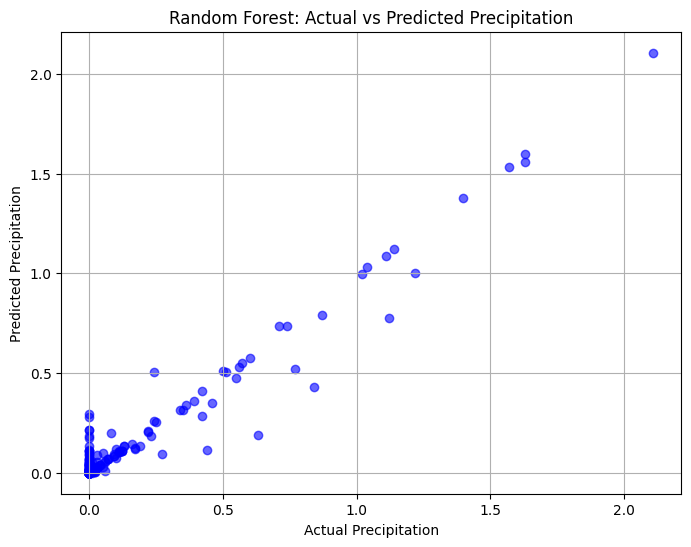

In [ ]:
# Scatter Plot for Actual vs Predicted (Random Forest)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='blue')  # dots instead of line
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.title('Random Forest: Actual vs Predicted Precipitation')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define base models
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42))
]

# Stacking Regressor
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=RandomForestRegressor(random_state=42)
)

# Train
stacking_model.fit(X_train_scaled, y_train)

# Predict
y_pred_stack = stacking_model.predict(X_test_scaled)

# Evaluate
mse_stack = mean_squared_error(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacking Regressor (Before Tuning) - MSE: {mse_stack:.4f}, MAE: {mae_stack:.4f}, R²: {r2_stack:.4f}")


Stacking Regressor (Before Tuning) - MSE: 0.0093, MAE: 0.0291, R²: 0.8890


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize model
gb_model = GradientBoostingRegressor(random_state=42)

# Grid Search
grid_search_gb = GridSearchCV(gb_model, param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
grid_search_gb.fit(X_train_scaled, y_train)

# Best Gradient Boosting model
best_gb = grid_search_gb.best_estimator_
print("Best GradientBoosting Parameters:", grid_search_gb.best_params_)


Best GradientBoosting Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}


In [ ]:
base_models = [
    ('rf', rf_best),
    ('gb', best_gb)
]

# Stacking Regressor with a final estimator
stacking_model = StackingRegressor(estimators=base_models,
                                   final_estimator=RandomForestRegressor(n_estimators=50, random_state=42))
stacking_model.fit(X_train_scaled, y_train)

# Predictions and evaluation for stacking regressor
y_pred_stack = stacking_model.predict(X_test_scaled)
mse_stack = mean_squared_error(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

# Print results
print(f"Stacking Regressor (After Tuning) - MSE: {mse_stack:.4f}, MAE: {mae_stack:.4f}, R²: {r2_stack:.4f}")

Stacking Regressor (After Tuning) - MSE: 0.0087, MAE: 0.0270, R²: 0.8964


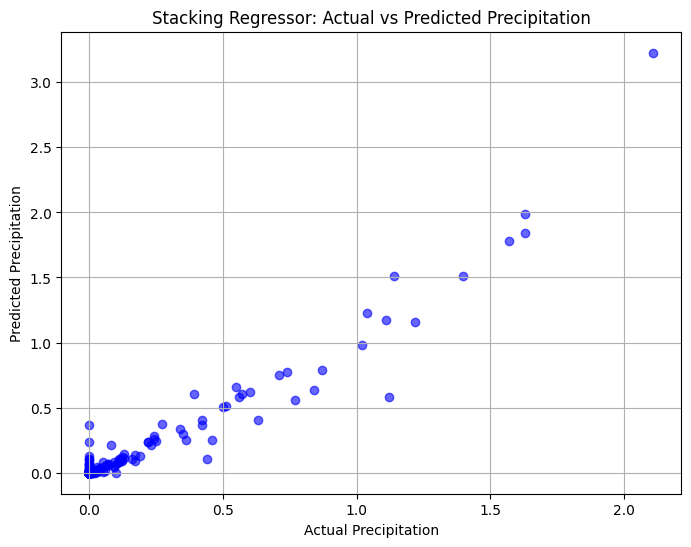

In [ ]:
# Scatter Plot for Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_stack, alpha=0.6, color='blue')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.title('Stacking Regressor: Actual vs Predicted Precipitation')
plt.grid(True)
plt.show()


In [ ]:
y = df['Precipit']
exog = df[['Precipit_lag_1', 'Precipit_3d_avg', 'day_of_week']]

train_size = int(len(df) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]


sarimax_model_default = SARIMAX(y_train, exog=exog_train, order=(1, 0, 1), seasonal_order=(0, 0, 1, 7))
results_default = sarimax_model_default.fit(disp=False)
y_pred_default = results_default.forecast(steps=len(y_test), exog=exog_test)

mse_default = mean_squared_error(y_test, y_pred_default)
mae_default = mean_absolute_error(y_test, y_pred_default)
r2_default = r2_score(y_test, y_pred_default)

mse_default, mae_default, r2_default

(0.04327918961853254, 0.09221650851056687, 0.48177178221299966)

In [ ]:
from itertools import product
p = d = q = P = D = Q = [0, 3]
s = [7]
param_grid = list(product(p, d, q, P, D, Q, s))

best_score = float("inf")
best_params = None
best_model = None

for params in param_grid:
    try:
        model = SARIMAX(y_train,
                        exog=exog_train,
                        order=(params[0], params[1], params[2]),
                        seasonal_order=(params[3], params[4], params[5], params[6]),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        forecast = results.forecast(steps=len(y_test), exog=exog_test)
        mse = mean_squared_error(y_test, forecast)
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = results
    except:
        continue

# Evaluate final model
forecast_final = best_model.forecast(steps=len(y_test), exog=exog_test)
mse_sarimax = mean_squ 3red_error(y_test, forecast_final)
mae_sarimax = mean_absolute_error(y_test, forecast_final)
r2_sarimax = r2_score(y_test, forecast_final)

mse_sarimax, mae_sarimax, r2_sarimax, best_params

(0.04257780368380777,
 0.09452132494365918,
 0.4901702292758263,
 (3, 0, 0, 0, 0, 3, 7))

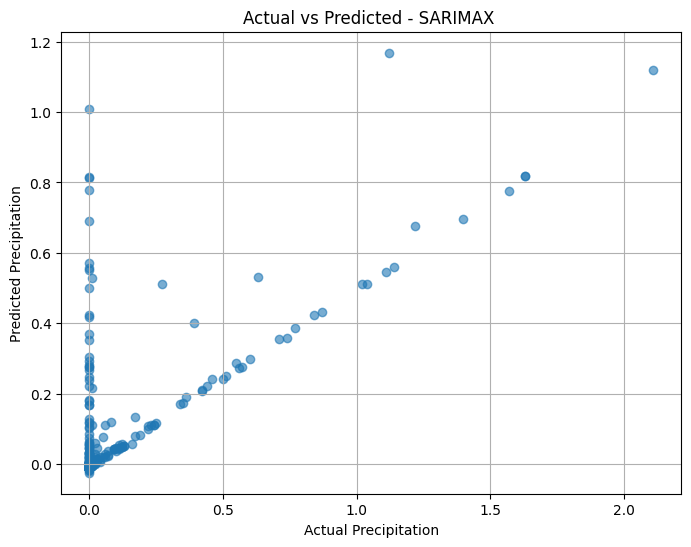

In [ ]:
# Scatter Plot for Actual vs Predicted (SARIMAX)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, forecast_final, alpha=0.6)
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.title('Actual vs Predicted - SARIMAX ')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences
def create_sequences(data, time_steps=14):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 14
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

# Build a basic LSTM model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

# Predict
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(np.c_[y_test, np.zeros((y_test.shape[0], scaled_data.shape[1]-1))])[:, 0]
y_pred_inv = scaler.inverse_transform(np.c_[y_pred, np.zeros((y_pred.shape[0], scaled_data.shape[1]-1))])[:, 0]

# Evaluate
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM (Without Tuning) - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
LSTM (Without Tuning) - MSE: 51.0424, MAE: 5.6461, R²: 0.6890


In [ ]:
!pip install -q keras-tuner

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping


# Preprocessing - Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Creating sequences
def create_sequences(data, time_steps=14):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 0])  # Assuming precipitation is the first column
    return np.array(X), np.array(y)

time_steps = 14
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

# Define Model Builder
def build_model(hp):
    model = Sequential()

    model.add(LSTM(
        units=hp.Int('units1', min_value=32, max_value=128, step=32),
        return_sequences=True,
        activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    model.add(LSTM(
        units=hp.Int('units2', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(
        optimizer='adam',
        loss='mse'
    )

    return model

# Set up Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True
)

# Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start Tuning
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_data=(X_test, y_test),
             callbacks=[early_stopping],
             verbose=1)

# Retrieve Best Model
best_model = tuner.get_best_models(num_models=1)[0]

# Make Predictions
y_pred = best_model.predict(X_test)

#  Inverse Transform Predictions and Actual
y_test_inv = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))], axis=1)
)[:, 0]

y_pred_inv = scaler.inverse_transform(
    np.concatenate([y_pred.reshape(-1, 1), np.zeros((y_pred.shape[0], scaled_data.shape[1]-1))], axis=1)
)[:, 0]

# Evaluation
mse_lstm = mean_squared_error(y_test_inv, y_pred_inv)
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
r2_lstm = r2_score(y_test_inv, y_pred_inv)

print(f"LSTM (Keras Tuner Optimized) - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")




Trial 10 Complete [00h 00m 24s]
val_loss: 0.011500939726829529

Best val_loss So Far: 0.010648960247635841
Total elapsed time: 00h 03m 33s
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
LSTM (Keras Tuner Optimized) - MSE: 51.0424, MAE: 5.6461, R²: 0.6890


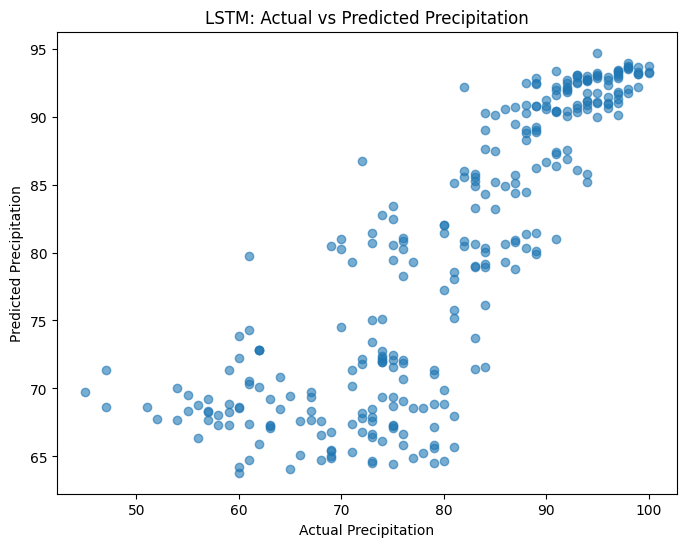

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.6)
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.title('LSTM: Actual vs Predicted Precipitation')
plt.show()


In [ ]:
print(f"Random Forest - MSE: {mse_rf:.4f}, MAE: {mae_rf:.4f}, R²: {r2_rf:.4f}")
print(f"Stacking Regressor - MSE: {mae_stack}, MAE: {r2_stack:.4f}, R²: {r2_stack}")
print(f"SARIMA - MSE: {mse_sarimax}, MAE: {mae_sarimax}, R²: {r2_sarimax:.4f}")
print(f"LSTM - MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}, R²: {r2_lstm:.4f}")


Random Forest - MSE: 0.0044, MAE: 0.0252, R²: 0.9472
Stacking Regressor - MSE: 0.02695598705501618, MAE: 0.8964, R²: 0.896384295441605
SARIMA - MSE: 0.04257780368380777, MAE: 0.09452132494365918, R²: 0.4902
LSTM - MSE: 47.8032, MAE: 5.3852, R²: 0.7087


In [ ]:
# Find the best model based on highest R²
r2_scores = {
    'Random Forest': r2_rf,
    'Stacking Regressor': r2_stack,
    'SARIMAX': r2_sarimax,
    'LSTM': r2_lstm
}

best_model_name = max(r2_scores, key=r2_scores.get)
print(f"\nBest model based on R² is: {best_model_name}")



Best model based on R² is: Random Forest


In [ ]:
# Select forecast model
if best_model_name == 'Random Forest':
    forecast_model = rf_best
    model_type = 'rf'
elif best_model_name == 'Stacking Regressor':
    forecast_model = stack_best_model
    model_type = 'stack'
elif best_model_name == 'LSTM':
    forecast_model = final_lstm_model
    model_type = 'lstm'
else:
    forecast_model = best_sarimax_model
    model_type = 'sarimax'

print(f"Forecasting will be performed using the {best_model_name} model.")

Forecasting will be performed using the Random Forest model.


In [ ]:
from datetime import timedelta

last_known_features = X_test_scaled[-1].reshape(1, -1)  # (1, number_of_features)

# Take input from user
start_date_input = input("Enter the forecast start date (YYYY-MM-DD): ")
end_date_input = input("Enter the forecast end date (YYYY-MM-DD): ")

start_date = pd.to_datetime(start_date_input)
end_date = pd.to_datetime(end_date_input)

n_days = (end_date - start_date).days + 1

# Initialize future feature set
future_preds = []
dates = []

X_future = last_known_features.copy()

for _ in range(n_days):
    # Predict precipitation
    pred = forecast_model.predict(X_future)[0]
    future_preds.append(pred)
    dates.append(start_date)
    start_date += timedelta(days=1)

    noise = np.random.normal(0, 0.01, size=X_future.shape)  # mean=0, std=0.01
    X_future = X_future + noise

# Assemble into DataFrame
forecast_df = pd.DataFrame({
    "Date": dates,
    "Predicted Precipitation": np.round(future_preds, 4)
})

print("\nPredicted Precipitation for Future Dates:")
print(forecast_df)


Enter the forecast start date (YYYY-MM-DD): 2025-05-10
Enter the forecast end date (YYYY-MM-DD): 2025-05-15

Predicted Precipitation for Future Dates:
        Date  Predicted Precipitation
0 2025-05-10                   0.0558
1 2025-05-11                   0.0575
2 2025-05-12                   0.0535
3 2025-05-13                   0.0557
4 2025-05-14                   0.0527
5 2025-05-15                   0.0546
